# Label Exploration

## Count the number of subjects with labels

In [1]:
import csv
from os import listdir
from os.path import exists

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in HBN label CSV

In [2]:
label_file_path = r"/imaging3/owenlab/bpho/Biobank Labels/Labels_Feb2_2021.csv"
labels = pd.read_csv(label_file_path, index_col='Identifiers', 
                     dtype='str')
label_subject_ids = labels['assessment WISC,EID']

print("Number of unique WISC subjects:", label_subject_ids.nunique())

Number of unique WISC subjects: 2936


### Read in subject IDs with FC

In [3]:
data_subject_ids = set()

for age in range(5, 19):
    age_dir = f'/imaging3/owenlab/bpho/python_power_fc/Age{age}'
    
    if not exists(age_dir):
        continue
    
    data_subject_ids = data_subject_ids.union(
        {folder[4:] for folder in listdir(age_dir) if folder.startswith("sub-")})

data = pd.DataFrame(data_subject_ids, columns=["subject_id"])
data = data.set_index("subject_id")
# display(data)
print("Number of Power FC subjects:", len(data_subject_ids))

Number of Power FC subjects: 722


## Clean labels

### Filter for age and WISC

In [4]:
ages = labels["assessment Basic_Demos,Age"]
wisc_labels = labels.filter(like="WISC").join(ages)
wisc_labels = wisc_labels[
    wisc_labels['assessment WISC,WISC_complete'] == '1']
wisc_labels = wisc_labels.set_index("assessment WISC,EID")
# display(wisc_labels)

### Get the list of bad subjects and remove them

In [5]:
bad_subject_file_path = r"/home/bpho/Documents/MSc_Research-Project/scratch_data/bad_subjects.csv"
bad_subjects = pd.read_csv(bad_subject_file_path, index_col='subject_id')
# display(bad_subjects)

clean_labels = wisc_labels[~wisc_labels.index.isin(bad_subjects.index)]
# display(clean_labels)

### Filter for subjects with FC data

In [6]:
subjects_with_labels = clean_labels.merge(
    data, left_index=True, right_index=True)
# display(subjects_with_labels)
subjects_with_labels.index.rename("assessment WISC,EID", inplace=True)
print(subjects_with_labels.columns)

Index(['assessment WISC,Administration', 'assessment WISC,Comment_ID',
       'assessment WISC,Data_entry', 'assessment WISC,Days_Baseline',
       'assessment WISC,PSCID', 'assessment WISC,START_DATE',
       'assessment WISC,Season', 'assessment WISC,Site',
       'assessment WISC,Study', 'assessment WISC,Visit_label',
       'assessment WISC,WISC_BD_Raw', 'assessment WISC,WISC_BD_Scaled',
       'assessment WISC,WISC_Coding_Raw', 'assessment WISC,WISC_Coding_Scaled',
       'assessment WISC,WISC_DS_Raw', 'assessment WISC,WISC_DS_Scaled',
       'assessment WISC,WISC_FRI', 'assessment WISC,WISC_FRI_Percentile',
       'assessment WISC,WISC_FRI_Sum', 'assessment WISC,WISC_FSIQ',
       'assessment WISC,WISC_FSIQ_Percentile', 'assessment WISC,WISC_FSIQ_Sum',
       'assessment WISC,WISC_FW_Raw', 'assessment WISC,WISC_FW_Scaled',
       'assessment WISC,WISC_MR_Raw', 'assessment WISC,WISC_MR_Scaled',
       'assessment WISC,WISC_PSI', 'assessment WISC,WISC_PSI_Percentile',
       'asses

## Write labels to CSV

In [7]:
print("Number of subjects with WISC labels:", len(subjects_with_labels))

Number of subjects with WISC labels: 577


In [8]:
csv_output_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects_with_WISC.csv"
subjects_with_labels.to_csv(csv_output_path)

## Plot label distribution

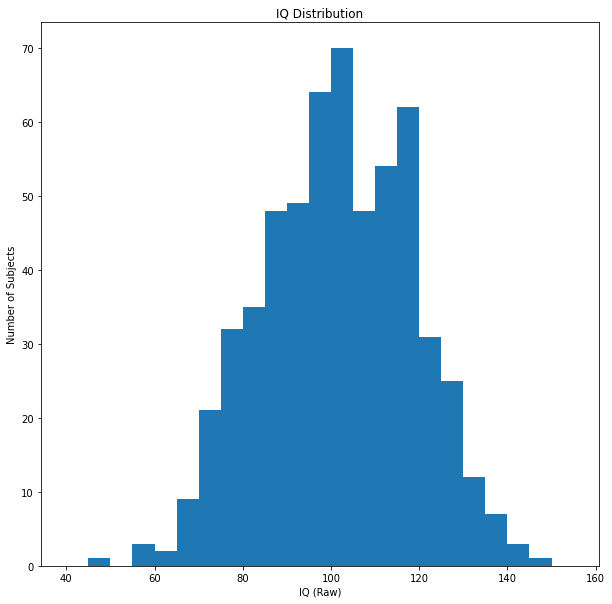

In [11]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=subjects_with_labels['assessment WISC,WISC_FSIQ'].astype(float), bins=range(40, 160, 5))
plt.title("IQ Distribution")
plt.xlabel('IQ (Raw)')
plt.ylabel('Number of Subjects')
plt.show()

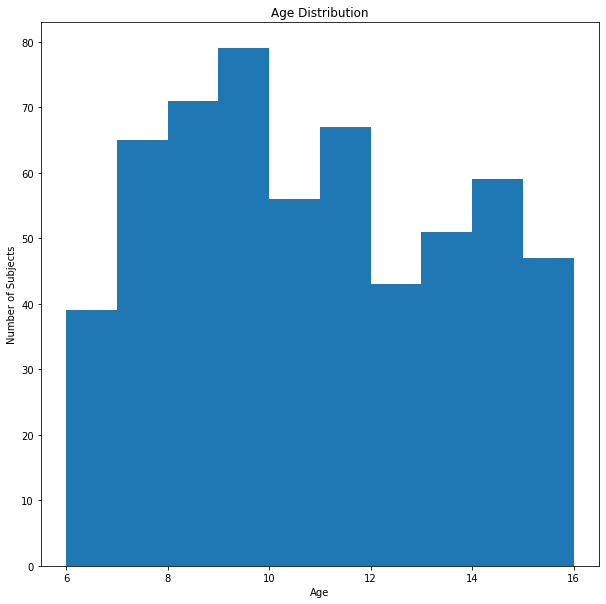

In [11]:
plt.figure(1, figsize=(10, 10))
plt.hist(x=subjects_with_labels['assessment Basic_Demos,Age'].astype(float), bins=range(6, 17, 1))
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Number of Subjects')
plt.show()

## Check relationship between Age and WISC

In [13]:
# Clean the original set of labels
clean_labels = labels[labels['assessment Basic_Demos,Age'] != "."]
clean_labels = clean_labels[clean_labels['assessment WISC,WISC_complete'] == '1']
clean_labels = clean_labels.dropna(axis='columns', how='all')

### Check WISC FSIQ

(2623,) (2623,) Avg IQ: 98.1422035836828
Slope: -0.6618316693912518, r2: 0.01175281679331119, p: 2.606101918286009e-08


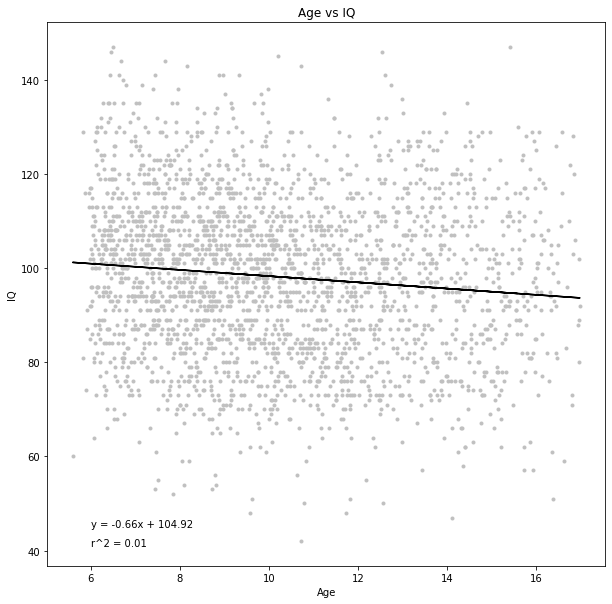

In [11]:
clean_labels = clean_labels.dropna(subset=['assessment WISC,WISC_FSIQ'])
wisc_fsiq = clean_labels['assessment WISC,WISC_FSIQ'].astype(int)
age = clean_labels['assessment Basic_Demos,Age'].astype(float)
print(age.shape, wisc_fsiq.shape, f"Avg IQ: {np.mean(wisc_fsiq)}")

m, b, r, p, stderr = stats.linregress(age, wisc_fsiq)
print(f"Slope: {m}, r2: {r**2}, p: {p}")

plt.figure(1, figsize=(10, 10))
plt.plot(age, wisc_fsiq, '.', color='silver')
plt.plot(age, (m * age) + b, '-', color='black')
plt.title("Age vs IQ")
plt.xlabel('Age')
plt.ylabel('IQ')
plt.annotate(f"y = {m:.2f}x + {b:.2f}", (6, 45))
plt.annotate(f"r^2 = {r**2:.2f}", (6, 41))
plt.show()

### Check WISC subtests

In [12]:
# Grab columns
wisc_col = 'assessment WISC'
wisc_raw_measures = [
    'WISC_BD_Raw', 
    'WISC_Similarities_Raw', 
    'WISC_MR_Raw',
    'WISC_DS_Raw',
    'WISC_Coding_Raw',
    'WISC_Vocab_Raw',
    'WISC_FW_Raw',
    'WISC_VP_Raw',
    'WISC_PS_Raw',
    'WISC_SS_Raw',
]
wisc_scaled_measure = [
    'WISC_BD_Scaled', 
    'WISC_Similarities_Scaled', 
    'WISC_MR_Scaled',
    'WISC_DS_Scaled',
    'WISC_Coding_Scaled',
    'WISC_Vocab_Scaled',
    'WISC_FW_Scaled',
    'WISC_VP_Scaled',
    'WISC_PS_Scaled',
    'WISC_SS_Scaled',
]
wisc_measures = np.array([wisc_raw_measures, wisc_scaled_measure]).flatten('F')

clean_labels = clean_labels.dropna(subset=[f'assessment WISC,{measure}' for measure in wisc_measures])
wisc_measures_data = {measure: clean_labels[f'{wisc_col},{measure}'].astype(int).to_numpy() 
                      for measure in wisc_measures}
age = clean_labels['assessment Basic_Demos,Age'].astype(float)

print("Num WISC measures:", len(wisc_measures_data))
print("Num subjects:", len(age))

Num WISC measures: 20
Num subjects: 2734


In [14]:
for measure, data in wisc_measures_data.items():
    lin_reg = stats.linregress(age, data)
    print(f"{measure} r-squared:: {lin_reg.rvalue**2:.4f}")
    print(f"{measure} p-value: {lin_reg.pvalue}")
    print("--------------------------------------------")

WISC_BD_Raw r-squared:: 0.2690
WISC_BD_Raw p-value: 3.4735864988208293e-188
--------------------------------------------
WISC_BD_Scaled r-squared:: 0.0097
WISC_BD_Scaled p-value: 2.6293729163658773e-07
--------------------------------------------
WISC_Similarities_Raw r-squared:: 0.3797
WISC_Similarities_Raw p-value: 1.34023132102074e-285
--------------------------------------------
WISC_Similarities_Scaled r-squared:: 0.0125
WISC_Similarities_Scaled p-value: 4.376204194825878e-09
--------------------------------------------
WISC_MR_Raw r-squared:: 0.3045
WISC_MR_Raw p-value: 1.0965902551838532e-217
--------------------------------------------
WISC_MR_Scaled r-squared:: 0.0000
WISC_MR_Scaled p-value: 0.739732448678067
--------------------------------------------
WISC_DS_Raw r-squared:: 0.3099
WISC_DS_Raw p-value: 2.3167530683376688e-222
--------------------------------------------
WISC_DS_Scaled r-squared:: 0.0002
WISC_DS_Scaled p-value: 0.5069587352886207
-----------------------------

In [1]:
plt.figure(1, figsize=(10, 10))
plt.scatter(age, wisc_measures_data['WISC_Coding_Raw'])
plt.scatter(age, wisc_measures_data['WISC_Coding_Scaled'])
plt.title("Age vs WISC Measure")
plt.xlabel('Age')
plt.ylabel('WISC_Vocab_Raw')
plt.show()

NameError: name 'plt' is not defined